### Main goal of this notebook is choosing the strongest features of RF classifier using `eli5` library.

We want to check if we can divide poisonous and edible mushrooms easily.

### Imports and basic data exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('mushrooms.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


Dataframe consists of categorical features.

Now, let's check if there are any features with only one value.

In [3]:
classes_with_max_1_value = [i for i in df.columns if df[i].value_counts().shape[0] < 2]
classes_with_max_1_value

['veil-type']

Histogram for confirmation.

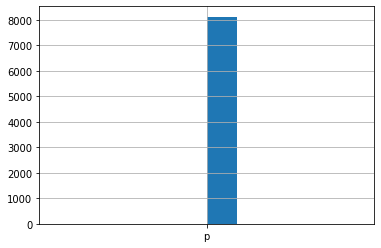

In [4]:
df['veil-type'].hist()

We can drop `veil-type` column - this is a redundant feature.

In [5]:
print('Before: ', df.shape)

df = df.drop(columns=classes_with_max_1_value)

print('After: ' , df.shape)

Before:  (8124, 23)
After:  (8124, 22)


### Transforming dataset

We want to vizualize our data using 2 principal components and label this data with `df['class']` values to see if poisonous and edible mushrooms can be easily divided. 

First, we need to split dataset to X and y and transform X into numerical values. To avoid wrong interpretation of features with multiple categorical values, we will transform features (X) into dummy data.

In [6]:
y = df.iloc[:,0] # class column
X = df.iloc[:,1:] 
X_dummies = pd.get_dummies(X)
X_dummies

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,0,0,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
8120,0,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
8121,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
8122,0,0,0,1,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0


# Random Forrest classification

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import eli5 #install package if not installed with conda-forge
from eli5.sklearn import  PermutationImportance

from random import randint

C:\Users\EDSMAZIE\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\EDSMAZIE\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [8]:
def eli5_top10_weights(X, y, test_size):
    """ 
    Chooses 10 strongest features, which are influencing RF model.
    Prints model score for train set, test set, confusion matrix and classification report
    Parameters: 
    X (pd.DataFrame): observations
    y (pd.Series): targets
    test_size
    Returns: 
    results (dict): 
        'train_score': float,
        'test_score': float,
        'confusion_matrix': ndarray, 
        'clasification_report': string / dict, 
        'top_10_feats_weights': pd.DataFrame
  
    """
    x_train, x_test, y_train, y_test = train_test_split(X.values, y, test_size = test_size, random_state = randint(0,20))
    model = RandomForestClassifier(max_depth=7).fit(x_train, y_train)
    
    print('='*60 +"\n")
    print('Score train: ', model.score(x_train, y_train))
    
    y_pred = model.predict(x_test)
    
    print('Score test: ', accuracy_score(y_test, y_pred))
    print('\nConfusion matrix:')
    print(confusion_matrix(y_test, y_pred))
    print('\nClassification report:')
    print(classification_report(y_test,y_pred))
    print('='*60 +"\n")
    
    perm = PermutationImportance(model).fit(x_train,y_train)
    
    results = {'train_score': model.score(x_train, y_train),
               'test_score': accuracy_score(y_test, y_pred),
              'confusion_matrix': confusion_matrix(y_test, y_pred),
              'clasification_report' : classification_report(y_test,y_pred),
              'top_10_feats_weights' : eli5.explain_weights_df(perm, feature_names = X_dummies.columns.tolist())[:10]}
    return results


### Creating 10 Random F classifiers and retrieving 10 strongest features of each forest.

In [9]:
results = [eli5_top10_weights(X_dummies, y, 0.25) for i in range(10)]


Score train:  1.0
Score test:  1.0

Confusion matrix:
[[1041    0]
 [   0  990]]

Classification report:
              precision    recall  f1-score   support

           e       1.00      1.00      1.00      1041
           p       1.00      1.00      1.00       990

    accuracy                           1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031



Score train:  1.0
Score test:  0.999015263417036

Confusion matrix:
[[1031    0]
 [   2  998]]

Classification report:
              precision    recall  f1-score   support

           e       1.00      1.00      1.00      1031
           p       1.00      1.00      1.00      1000

    accuracy                           1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031



Score train:  1.0
Score test:  1.0

Confusion matrix:
[[1076    0]
 [   0  955]]

Classification report:
            

### Counting number of features in results

In [10]:
feats_counter ={}

for i in results:
    temp_feats = i['top_10_feats_weights'].feature
    for feat in temp_feats:
        if feat in feats_counter:
            feats_counter[feat] += 1
        else:
            feats_counter[feat] = 1
feats_counter

{'odor_n': 10,
 'spore-print-color_r': 10,
 'gill-size_b': 8,
 'population_v': 8,
 'bruises_t': 5,
 'population_c': 3,
 'stalk-root_c': 3,
 'gill-color_h': 1,
 'odor_s': 3,
 'odor_y': 3,
 'stalk-root_b': 5,
 'spore-print-color_w': 5,
 'bruises_f': 3,
 'habitat_d': 1,
 'cap-color_w': 1,
 'gill-size_n': 6,
 'gill-attachment_a': 2,
 'gill-attachment_f': 1,
 'habitat_l': 1,
 'ring-type_e': 1,
 'stalk-shape_t': 3,
 'stalk-shape_e': 2,
 'ring-number_o': 4,
 'odor_f': 2,
 'gill-color_g': 2,
 'ring-number_t': 3,
 'ring-type_p': 3,
 'habitat_m': 1}

### Counting number of features before dummy data transformation

In [11]:
main_feats = {}

for feat in feats_counter:
    feat_name = feat.split('_')[0]
    if feat_name in main_feats:
        main_feats[feat_name] += feats_counter[feat]
    else:
        main_feats[feat_name] = feats_counter[feat]

main_feats = sorted(main_feats.items(), key=lambda item: item[1], reverse=True)
main_feats

[('odor', 18),
 ('spore-print-color', 15),
 ('gill-size', 14),
 ('population', 11),
 ('bruises', 8),
 ('stalk-root', 8),
 ('ring-number', 7),
 ('stalk-shape', 5),
 ('ring-type', 4),
 ('gill-color', 3),
 ('habitat', 3),
 ('gill-attachment', 3),
 ('cap-color', 1)]

### Chossing 5 most common main features

In [12]:
feats_final_list = [i[0] for i in main_feats[:5]]
feats_final_list

['odor', 'spore-print-color', 'gill-size', 'population', 'bruises']

### Creating all necessary dummy features from chosen main features.

In [13]:
dummies_feats = [i for i in X_dummies.columns if i.startswith(tuple(feats_final_list))]
dummies_feats

['bruises_f',
 'bruises_t',
 'odor_a',
 'odor_c',
 'odor_f',
 'odor_l',
 'odor_m',
 'odor_n',
 'odor_p',
 'odor_s',
 'odor_y',
 'gill-size_b',
 'gill-size_n',
 'spore-print-color_b',
 'spore-print-color_h',
 'spore-print-color_k',
 'spore-print-color_n',
 'spore-print-color_o',
 'spore-print-color_r',
 'spore-print-color_u',
 'spore-print-color_w',
 'spore-print-color_y',
 'population_a',
 'population_c',
 'population_n',
 'population_s',
 'population_v',
 'population_y']

### Traning final model on chosen dummy features

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X_dummies[dummies_feats].values, y, test_size = 0.25)
x_train.shape

(6093, 28)

In [15]:
model = RandomForestClassifier().fit(x_train, y_train)
print('Score train: ', model.score(x_train, y_train))
y_pred = model.predict(x_test)
print('Score test: ', accuracy_score(y_test, y_pred))
print('\nConfusion matrix:')
print(confusion_matrix(y_test, y_pred))
print('\nClassification report:')
print(classification_report(y_test,y_pred))

Score train:  0.995732808140489
Score test:  0.9970457902511078

Confusion matrix:
[[1045    0]
 [   6  980]]

Classification report:
              precision    recall  f1-score   support

           e       0.99      1.00      1.00      1045
           p       1.00      0.99      1.00       986

    accuracy                           1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031



Final model's metrics are unreasonably high. Let's investigate chosen features.

# Inspecting odor column:

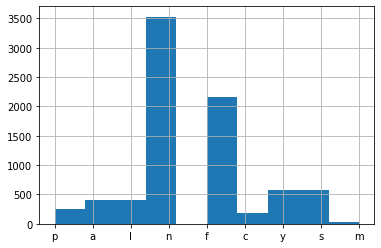

In [16]:
df.odor.hist()

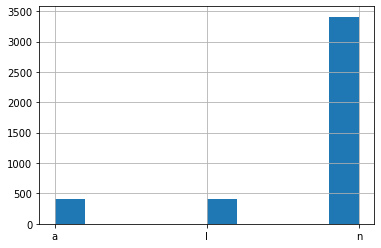

In [17]:
df.loc[df['class'] != 'p', 'odor'].hist()

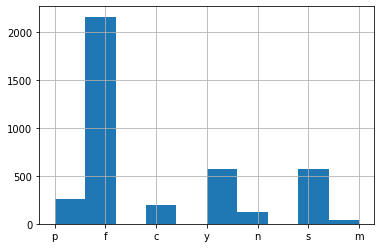

In [18]:
df.loc[df['class'] == 'p', 'odor'].hist()

In [19]:
poisonous_list = df.loc[df['class'] == 'p', 'odor'].value_counts().index
poisonous_list

Index(['f', 'y', 's', 'p', 'c', 'n', 'm'], dtype='object')

In [20]:
edible_list = df.loc[df['class'] == 'e', 'odor'].value_counts().index
edible_list

Index(['n', 'a', 'l'], dtype='object')

In [21]:
list(set(poisonous_list).intersection(edible_list))

['n']

In [22]:
df.loc[df['odor'] == 'n', 'class'].value_counts()

e    3408
p     120
Name: class, dtype: int64

# Conclusion:

Using odor column we can expect extremely high 98-99 % accurancy score for this dataset because intersection between `odor` feature values for `poisonous` and `edible` mushrooms is only one symbol: `n`.